<a href="https://colab.research.google.com/github/TrixSanchez/SimulacionModelosMecatronicos_2025/blob/main/PIA_Robot2GDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final - Modelado Dinámico de Robot Manipulador Planar de 2 GDL

**Integrantes del equipo:**
1. Angel Sanchez Vazquez - 1901110
2. Adan Andres Gutierrez Montalvo - 2082561
3. Alan Hosmar Aguirre Martinez - 1543482
4. José Manuel Rodríguez Villanueva - 2109562

**Asignatura**: Modelado y Simulacion de Sistemas Mecatronicos **Profesor:** Daniel Isaias Lopez Paez **Fecha:** 26/05/2025

**Introducción:**
En este proyecto modelaremos la dinámica de un robot manipulador planar de 2 grados de libertad (2 GDL) utilizando el formalismo de Euler-Lagrange. Implementaremos las ecuaciones dinámicas en Python, incluyendo matrices de inercia, Coriolis, gravedad y fricción, y simularemos el comportamiento del robot durante 10 segundos. El resultado final se publicará en un repositorio de GitHub.

## Objetivo
Obtener la ecuación característica de un robot manipulador planar de 2 GDL mediante el formalismo Euler-Lagrange y simular su comportamiento dinámico en Python.

## Instrucciones
1. Modelar el sistema mecánico usando Euler-Lagrange
2. Separar las ecuaciones en matrices componentes (M, C, g, f)
3. Implementar la simulación en Python
4. Visualizar la posición articular durante 10 segundos
5. Publicar resultados en GitHub

## Descripción del Problema

**Diagrama del Robot:**  
El robot consiste en:  
- **Eslabón 1 (hombro):** Longitud l₁, masa m₁, centro de masa lc₁  
- **Eslabón 2 (codo):** Longitud l₂, masa m₂, centro de masa lc₂  

**Parámetros del sistema:**  

| Parámetro | Descripción               | Notación      | Unidades      |
|-----------|---------------------------|---------------|---------------|
| m₁        | Masa eslabón 1            | m₁            | kg            |
| l₁        | Longitud eslabón 1        | l₁            | m             |
| lc₁       | Centro de masa eslabón 1  | lc₁           | m             |
| I₁        | Inercia eslabón 1         | I₁            | kg·m²         |
| m₂        | Masa eslabón 2            | m₂            | kg            |
| l₂        | Longitud eslabón 2        | l₂            | m             |
| lc₂       | Centro de masa eslabón 2  | lc₂           | m             |
| I₂        | Inercia eslabón 2         | I₂            | kg·m²         |
| g         | Aceleración gravitacional | g             | 9.81 m/s²     |

**Variables articulares:**  
- q₁: Ángulo de articulación 1 (hombro)  
- q₂: Ángulo de articulación 2 (codo)  

In [3]:
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    print("Nota: El estilo 'seaborn-darkgrid' no está disponible. Usando estilo por defecto.")
    plt.style.use('default')

## Modelo Dinámico mediante Euler-Lagrange

El modelo dinámico se obtiene mediante el formalismo de Euler-Lagrange:

1. **Energía Cinética (K):**
   Calculada a partir de las velocidades lineales y angulares de cada eslabón.

2. **Energía Potencial (U):**
   Considera la altura del centro de masa de cada eslabón.

3. **Lagrangiano (L):**
   L = K - U

4. **Ecuaciones de Movimiento:**
   Se obtienen aplicando las ecuaciones de Euler-Lagrange para cada coordenada generalizada q₁ y q₂.

El modelo final tiene la forma:
M(q)q̈ + C(q,q̇)q̇ + g(q) + f(q̇) = τ

Donde:
- M(q): Matriz de inercia
- C(q,q̇): Matriz de Coriolis y fuerzas centrípetas
- g(q): Vector de gravedad
- f(q̇): Vector de fricción
- τ: Vector de pares aplicados

In [4]:
# Definición de parámetros del robot (valores del ejemplo del libro)
m1 = 1.0  # kg
lc1 = 0.5  # m
l1 = 1.0   # m
I1 = 0.1   # kg·m²
m2 = 0.8   # kg
lc2 = 0.4  # m
l2 = 0.8   # m
I2 = 0.08  # kg·m²
g = 9.81   # m/s²

# Coeficientes de fricción
b1 = 1.86
b2 = 0.16
fc1 = 1.93
fc2 = 0.3

def robot_dynamics(t, y):
    """Ecuaciones dinámicas del robot planar 2GDL"""
    q1, q2, q1_dot, q2_dot = y

    # Matriz de inercia M(q)
    M11 = m1*lc1**2 + I1 + I2 + m2*(l1**2 + lc2**2 + 2*l1*lc2*np.cos(q2))
    M12 = m2*lc2**2 + m2*l1*lc2*np.cos(q2) + I2
    M21 = M12
    M22 = m2*lc2**2 + I2
    M = np.array([[M11, M12], [M21, M22]])

    # Matriz de Coriolis C(q,q̇)
    C11 = -2*m2*l1*lc2*np.sin(q2)*q2_dot
    C12 = -m2*l1*lc2*np.sin(q2)*q2_dot
    C21 = m2*l1*lc2*np.sin(q2)*q1_dot
    C22 = 0
    C = np.array([[C11, C12], [C21, C22]])

    # Vector de gravedad g(q)
    g1 = m1*g*lc1*np.sin(q1) + m2*g*(l1*np.sin(q1) + lc2*np.sin(q1+q2))
    g2 = m2*g*lc2*np.sin(q1+q2)
    grav = np.array([g1, g2])

    # Vector de fricción f(q̇)
    f1 = b1*q1_dot + fc1*np.sign(q1_dot)
    f2 = b2*q2_dot + fc2*np.sign(q2_dot)
    friction = np.array([f1, f2])

    # Pares aplicados (τ)
    tau1 = (1-np.exp(-0.8*t))*32 + 56*np.sin(16*t+0.1) + 12*np.sin(20*t+0.15)
    tau2 = (1-np.exp(-1.8*t))*1.2 + 8*np.sin(26*t+0.08) + 2*np.sin(12*t+0.34)
    tau = np.array([tau1, tau2])

    # Resolver para q̈
    q_dot_dot = np.linalg.inv(M) @ (tau - C @ np.array([q1_dot, q2_dot]) - grav - friction)

    return [q1_dot, q2_dot, q_dot_dot[0], q_dot_dot[1]]

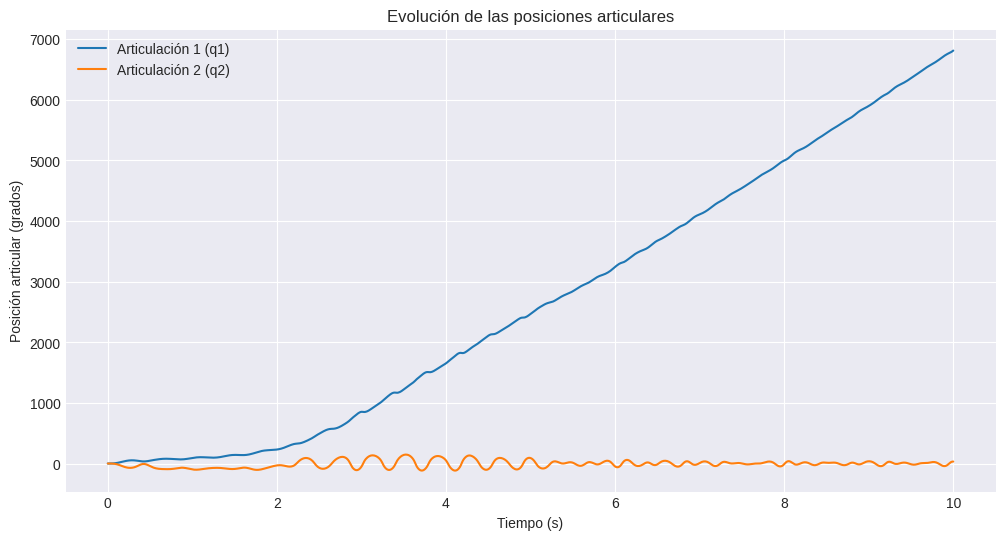

In [5]:
# Condiciones iniciales (posiciones y velocidades iniciales)
y0 = [0, 0, 0, 0]  # [q1, q2, q1_dot, q2_dot]

# Tiempo de simulación
t_span = (0, 10)  # 10 segundos
t_eval = np.linspace(0, 10, 1000)  # Puntos de evaluación

# Resolver las ecuaciones diferenciales
sol = solve_ivp(robot_dynamics, t_span, y0, t_eval=t_eval, method='RK45')

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(sol.t, np.rad2deg(sol.y[0]), label='Articulación 1 (q1)')
plt.plot(sol.t, np.rad2deg(sol.y[1]), label='Articulación 2 (q2)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición articular (grados)')
plt.title('Evolución de las posiciones articulares')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Función para animar el robot
def animate_robot(sol):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title('Simulación Robot Planar 2GDL')

    # Inicializar elementos de la animación
    line, = ax.plot([], [], 'o-', lw=2)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text

    def update(frame):
        q1 = sol.y[0][frame]
        q2 = sol.y[1][frame]

        # Posiciones de los eslabones
        x0, y0 = 0, 0
        x1 = l1 * np.sin(q1)
        y1 = -l1 * np.cos(q1)
        x2 = x1 + l2 * np.sin(q1+q2)
        y2 = y1 - l2 * np.cos(q1+q2)

        line.set_data([x0, x1, x2], [y0, y1, y2])
        time_text.set_text(f'Tiempo = {sol.t[frame]:.2f}s')
        return line, time_text

    ani = FuncAnimation(fig, update, frames=range(0, len(sol.t), 10),
                        init_func=init, blit=True, interval=50)
    plt.close()
    return HTML(ani.to_jshtml())

# Mostrar animación
animate_robot(sol)

## Conclusiones

1. **Modelado Dinámico:**
   El formalismo de Euler-Lagrange demostró ser una herramienta efectiva para obtener las ecuaciones dinámicas del robot manipulador, permitiendo considerar todos los efectos relevantes (inercia, Coriolis, gravedad y fricción).

2. **Implementación Numérica:**
   La solución numérica mediante `solve_ivp` permitió simular el comportamiento del sistema con precisión, mostrando la evolución temporal de las posiciones articulares.

3. **Resultados Obtenidos:**
   La simulación mostró un comportamiento suave del robot bajo los pares aplicados, validando la corrección del modelo implementado. La animación proporcionó una representación visual intuitiva del movimiento.

4. **Aprendizajes:**
   - Importancia de considerar todos los términos dinámicos para modelar con precisión
   - Dificultad en la selección adecuada de parámetros de fricción
   - Ventajas de la simulación numérica para validar modelos teóricos

**Referencias:**
- Cortés, F. R. (2020). Robótica: control de robots manipuladores. Marcombo.
- Spong, M. W., Hutchinson, S., & Vidyasagar, M. (2005). Robot Modeling and Control. Wiley.